In [60]:
from IPython.display import HTML
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

In [92]:
import openml as oml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import time

from scipy.stats import uniform

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV 

from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import roc_auc_score

import mglearn

# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [97]:
# Please fill in your names here
NAME_STUDENT_1 = "Celine Verhoef"
NAME_STUDENT_2 = "Jan Blans"

## MoneyBall (5 points, 1+2+1+1)
In the early 2000s, 2 baseball scouts completely changed the game of baseball by analysing the available data about baseball players and hiring the best ones.
The [MoneyBall dataset](https://www.openml.org/d/41021) contains this data (click the link for more details). The goal is to accurately predict the number of 'runs' each player can score. 

In [93]:
moneyball = oml.datasets.get_dataset(41021) # Download MoneyBall data
# Get the predictors X and the target y
X, y, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute, return_attribute_names=True)
# Describe the data with pandas, just to get an overview
ballframe = pd.DataFrame(X, columns=attribute_names)
ballframe.describe()

Team       League         Year           RA            W  \
count  1232.000000  1232.000000  1232.000000  1232.000000  1232.000000   
mean     15.669642     0.500000  1988.957764   715.081970    80.904221   
std       9.720413     0.500203    14.819622    93.079941    11.458138   
min       0.000000     0.000000  1962.000000   472.000000    40.000000   
25%       7.000000     0.000000  1976.750000   649.750000    73.000000   
50%      16.000000     0.500000  1989.000000   709.000000    81.000000   
75%      23.000000     1.000000  2002.000000   774.250000    89.000000   
max      38.000000     1.000000  2012.000000  1103.000000   116.000000   

               OBP          SLG           BA     Playoffs  RankSeason  \
count  1232.000000  1232.000000  1232.000000  1232.000000  244.000000   
mean      0.326331     0.397342     0.259273     0.198052    2.122951   
std       0.015013     0.033267     0.012907     0.398696    1.738350   
min       0.277000     0.301000     0.214000     0.000000    0.000000   
25%       0.317000     0.375000     0.251000     0.000000    1.000000   
50%       0.326000     0.396000     0.260000     0.000000    2.000000   
75%       0.337000     0.421000     0.268000     0.000000    3.000000   
max       0.373000     0.491000     0.294000     1.000000    7.000000   

       RankPlayoffs            G        OOBP        OSLG  
count    244.000000  1232.000000  420.000000  420.000000  
mean       1.717213     3.918831    0.332264    0.419743  
std        1.095234     0.624366    0.015295    0.026510  
min        0.000000     0.000000    0.294000    0.346000  
25%        1.000000     4.000000    0.321000    0.401000  
50%        2.000000     4.000000    0.331000    0.419000  
75%        3.000000     4.000000    0.343000    0.438000  
max        4.000000     7.000000    0.384000    0.499000

1 . Visually explore the data. Plot the distribution of each feature (e.g. histograms), as well as the target. Visualize the dependency of the target on each feature (use a 2d scatter plot). Is there anything that stands out? Is there something that you think might require special treatment?
- Feel free to create additional plots that help you understand the data
- Only visualize the data, you don't need to change it (yet)

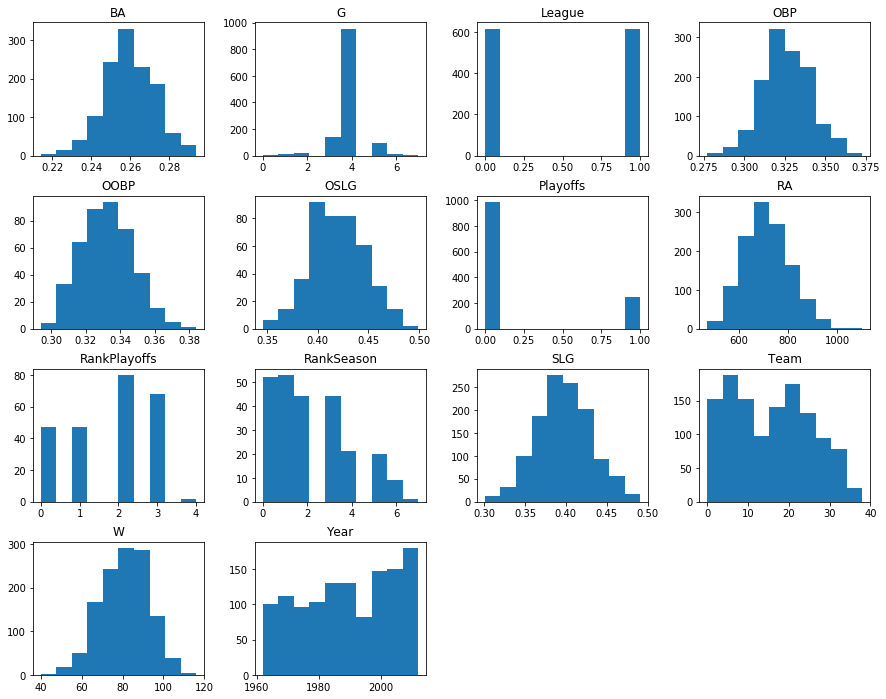

In [3]:
# Histograms of each feature 
pd.DataFrame.hist(ballframe, grid = False, figsize=(15, 12))
fig = plt.gcf()

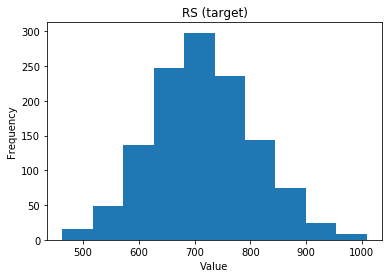

In [98]:
# Histogram of the target (RS)
plt.hist(y)
plt.title("RS (target)")
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.gcf()

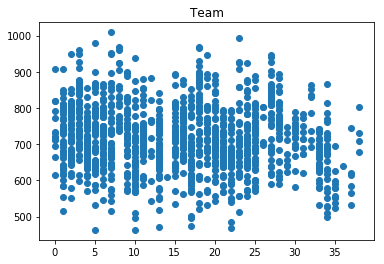

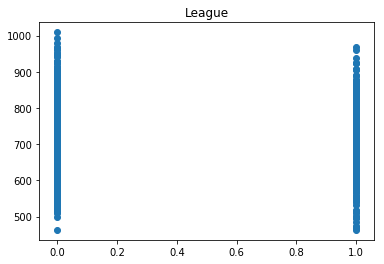

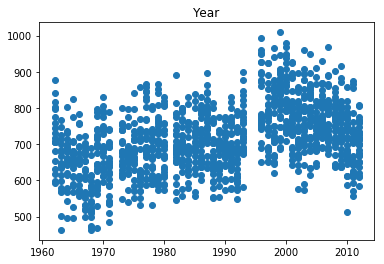

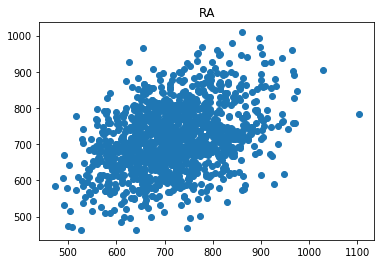

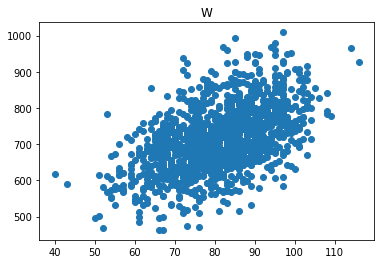

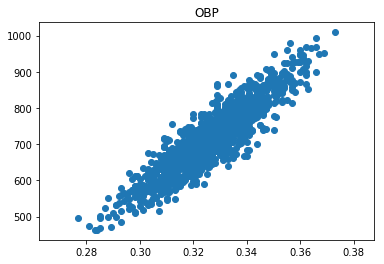

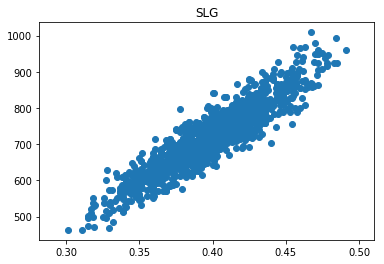

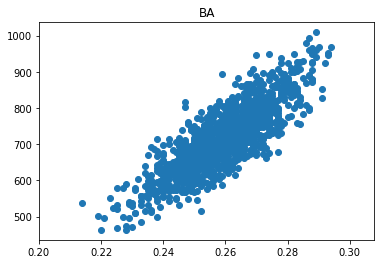

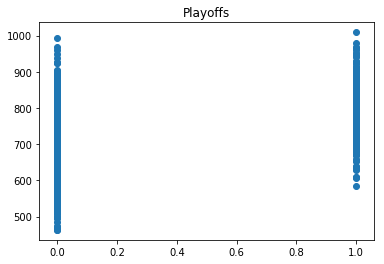

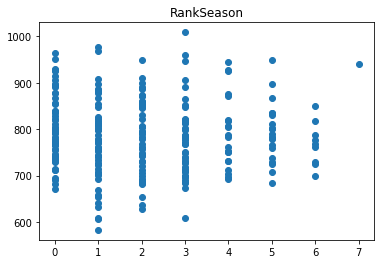

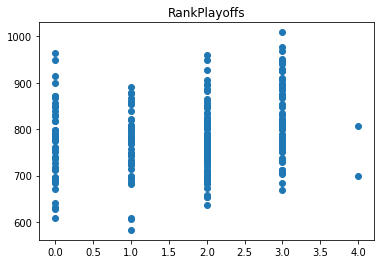

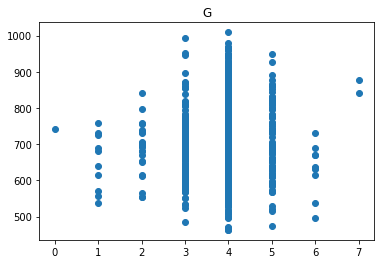

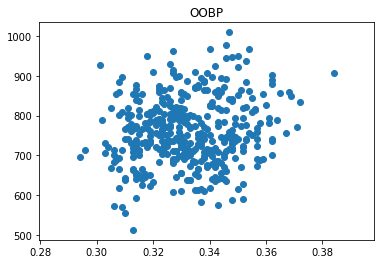

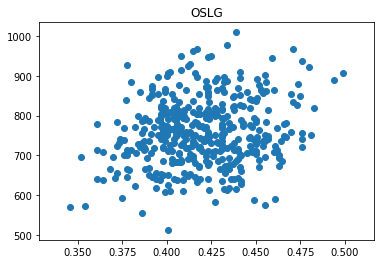

In [5]:
# dependency of the target on each feature (2d scatter plot)
for i in range(14):
    plt.scatter(ballframe.iloc[:,i], y)
    plt.title(ballframe.iloc[:,i].name)
    plt.show()

**Visual exploration**

We plotted histograms of all the features and the target. We can devide the features in the two obvious groups: 
- Nominal: 'G', 'League', 'Playoffs', 'RankSeason', 'RankPlayoffs' and 'Team'
- Numeric: 'BA, 'OBP', 'OOBP', 'OSLG', 'RA', 'SLG', 'W',and  'Year' 

When we compare the shapes of the histograms, we see that the shape of OBP, SLG and BA is very similar to the shape of the target. However, this is no guarantee that there is a dependency between the feature and the target. Namely, OOBP and OSLG also show a similar shape in the histogram, although we will see that no dependency is visible in the 2D scatter plot. 

Special treatment might be required for the nominal features. They are not always ordinal or it is unclear whether the feature can predict anything for the target.

When we plot the dependency of the target on eacht feature in a 2D scatter plot, we see a clear linear dependency of the target on the features `OBP`, `SLG` and `BA`. Also the features `RA` and `W` seem to show some linear dependency of the target, but this is not that obvious and we are not sure about this fact. The features `OOBP` and `OSLG` tend to have some linear depency, but this is hard to conclude from these scatter plots. More exploration and/or analysis should be performed to say whether this is the case.

2 . Compare all linear regression algorithms that we covered in class (Linear Regression, Ridge, Lasso and ElasticNet), as well as kNN. Evaluate using cross-validation and the $R^2$ score, with the default parameters. Does scaling the data with StandardScaler help? Provide a concise but meaningful interpretation of the results.
- Preprocess the data as needed (e.g. are there nominal features that are not ordinal?). If you don't know how to proceed, remove the feature and continue.

In [16]:
# Preprocess the data 

# We remove the features with a lot of missing values, which are: RankSeason, RankPLayoffs, OOBP and OSLG.
# We also remove the features that are nominal but not ordinal, which are: Playoffs, Team and League

newBallframe = ballframe[['RA', 'W', 'OBP', 'SLG', 'BA', 'Year', 'G']]
X_train, X_test, y_train, y_test = train_test_split(newBallframe, y)

In [17]:
# Evaluate the regression algorithms using cross-validation and the R^2 score

# Linear Regression
lr = LinearRegression().fit(X_train, y_train)

print("Linear Regression")
print("Training set score (R^2): {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score (R^2): {:.2f}".format(lr.score(X_test, y_test)))
print("Cross-validation scores: {}".format(cross_val_score(lr, newBallframe, y)))

# Ridge 
ridge = Ridge().fit(X_train, y_train)

print("")
print("Ridge")
print("Training set score (R^2): {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score (R^2): {:.2f}".format(ridge.score(X_test, y_test)))
print("Cross-validation scores: {}".format(cross_val_score(ridge, newBallframe, y)))

# Lasso
lasso = Lasso().fit(X_train, y_train)

print("")
print("Lasso")
print("Training set score (R^2): {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score (R^2): {:.2f}".format(lasso.score(X_test, y_test)))
print("Cross-validation scores: {}".format(cross_val_score(lasso, newBallframe, y)))

# ElasticNet
elasticNet = ElasticNet().fit(X_train, y_train)

print("")
print("ElasticNet")
print("Training set score: {:.2f}".format(elasticNet.score(X_train, y_train)))
print("Test set score: {:.2f}".format(elasticNet.score(X_test, y_test)))
print("Cross-validation scores: {}".format(cross_val_score(elasticNet, newBallframe, y)))

# kNN
knn = KNeighborsRegressor().fit(X_train, y_train)

print("")
print("kNN")
print("Training set score: {:.2f}".format(knn.score(X_train, y_train)))
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))
print("Cross-validation scores: {}".format(cross_val_score(knn, newBallframe, y)))

Linear Regression
Training set score (R^2): 0.95
Test set score (R^2): 0.94
Cross-validation scores: [0.9204131  0.93001184 0.93524479]

Ridge
Training set score (R^2): 0.89
Test set score (R^2): 0.88
Cross-validation scores: [0.83152767 0.87507634 0.85810714]

Lasso
Training set score (R^2): 0.86
Test set score (R^2): 0.86
Cross-validation scores: [0.80245358 0.84757568 0.82858613]

ElasticNet
Training set score: 0.86
Test set score: 0.86
Cross-validation scores: [0.80166554 0.84788912 0.82885732]

kNN
Training set score: 0.84
Test set score: 0.73
Cross-validation scores: [0.54142045 0.7002983  0.51544037]


In [18]:
# Scale the data with StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scale(y_train)
y_test_scaled = scale(y_test)
y_scaled = scale(y)

In [19]:
# Results after scaling

# Linear Regression
lr = LinearRegression().fit(X_train_scaled, y_train_scaled)

print("Linear Regression")
print("Training set score (R^2): {:.2f}".format(lr.score(X_train_scaled, y_train_scaled)))
print("Test set score (R^2): {:.2f}".format(lr.score(X_test_scaled, y_test_scaled)))
print("Cross-validation scores: {}".format(cross_val_score(lr, scaler.transform(newBallframe), y_scaled)))

# Ridge 
ridge = Ridge().fit(X_train_scaled, y_train_scaled)

print("")
print("Ridge")
print("Training set score (R^2): {:.2f}".format(ridge.score(X_train_scaled, y_train_scaled)))
print("Test set score (R^2): {:.2f}".format(ridge.score(X_test_scaled, y_test_scaled)))
print("Cross-validation scores: {}".format(cross_val_score(ridge, scaler.transform(newBallframe), y_scaled)))

# Lasso
lasso = Lasso().fit(X_train_scaled, y_train_scaled)

print("")
print("Lasso")
print("Training set score (R^2): {:.2f}".format(lasso.score(X_train_scaled, y_train_scaled)))
print("Test set score (R^2): {:.2f}".format(lasso.score(X_test_scaled, y_test_scaled)))
print("Cross-validation scores: {}".format(cross_val_score(lasso, scaler.transform(newBallframe), y_scaled)))

# ElasticNet
elasticNet = ElasticNet().fit(X_train_scaled, y_train_scaled)

print("")
print("ElasticNet")
print("Training set score: {:.2f}".format(elasticNet.score(X_train_scaled, y_train_scaled)))
print("Test set score: {:.2f}".format(elasticNet.score(X_test_scaled, y_test_scaled)))
print("Cross-validation scores: {}".format(cross_val_score(elasticNet, scaler.transform(newBallframe), y_scaled)))

# kNN
knn = KNeighborsRegressor().fit(X_train_scaled, y_train_scaled)

print("")
print("kNN")
print("Training set score: {:.2f}".format(knn.score(X_train_scaled, y_train_scaled)))
print("Test set score: {:.2f}".format(knn.score(X_test_scaled, y_test_scaled)))
print("Cross-validation scores: {}".format(cross_val_score(knn, scaler.transform(newBallframe), y_scaled)))

Linear Regression
Training set score (R^2): 0.95
Test set score (R^2): 0.94
Cross-validation scores: [0.92040937 0.93001061 0.93523535]

Ridge
Training set score (R^2): 0.95
Test set score (R^2): 0.94
Cross-validation scores: [0.92050353 0.93000317 0.93540807]

Lasso
Training set score (R^2): 0.00
Test set score (R^2): 0.00
Cross-validation scores: [-0.60077655  0.00175688 -0.80370831]

ElasticNet
Training set score: 0.55
Test set score: 0.54
Cross-validation scores: [0.19998238 0.56538321 0.00785162]

kNN
Training set score: 0.94
Test set score: 0.90
Cross-validation scores: [0.87950729 0.88252579 0.82312909]


**Model comparison**

We first discuss the scores of the algorithms before scaling the data. Linear regression has for both the training set and the test set a high $R^2$ score that is close to 1. Based on cross-validation, the models are stable and more than 90% accurate. The scores of Ridge, Lasso and ElasticNet are very similar and are slightly less than the scores of Linear Regression. The kNN scores are even less and based on the cross-validation the models are not very stable.

**Scaling**

After scaling, we see that the scores change differently depending on the algorithm. The Linear Regression model stays the same. The Ridge model and the kNN increase their test score a lot. 

The ElasticNet decreases in value. We also see a big difference in the cross validation scores. This indicates a very instable model. Therefore scaling is not a good preprocessing method for The ElasticNet.

The Lasso model gives back the new value zero. This is equivalent to "a constant model that always predicts the expected value of y, disregarding the input features".

3 . Do a default, shuffled train-test split and optimize the linear models for the degree of regularization ($alpha$) and choice of penalty (L1/L2). For Ridge and  Lasso, plot a curve showing the effect of the training and test set performance ($R^2$) while increasing the degree of regularization for different penalties. For ElasticNet, plot a heatmap $alpha \times l1\_ratio \rightarrow R^2$ using test set performance.
Report the optimal performance. Again, provide a concise but meaningful interpretation. What does the regularization do? Can you get better results?
- Think about how you get the L1/L2 loss. This is not a hyperparameter in regression.
- We've seen how to generate such heatmaps in Lecture 3.

In [94]:
# Preprocess the data also for this question

# We remove the features with a lot of missing values, which are: RankSeason, RankPLayoffs, OOBP and OSLG.
# We also remove the features that are nominal but not ordinal, which are: Playoffs, Team and League

newBallframe = ballframe[['RA', 'W', 'OBP', 'SLG', 'BA', 'Year', 'G']]
X_train, X_test, y_train, y_test = train_test_split(newBallframe, y)

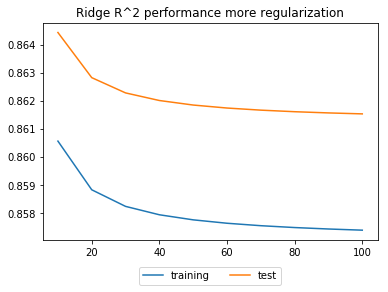

0.864434386416729


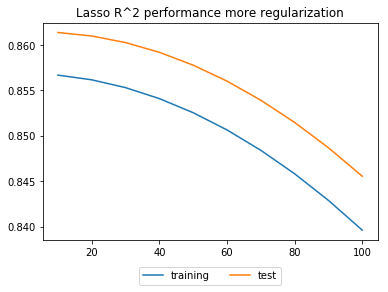

0.861384308476759


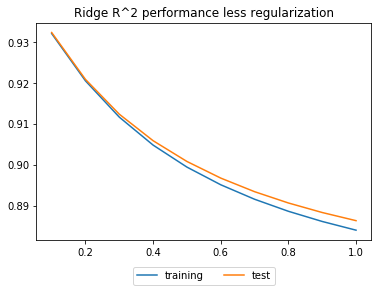

0.9323313509416585


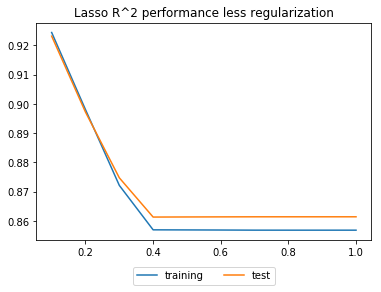

0.92319406089046


In [62]:
# For Ridge and Lasso, plot a curve showing the effect of the training and test set performance (R^2) 
# while increasing the degree of regularization for different penalties. 

alpha = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # More regularization
alpha_less = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # Less regularization

# Ridge regression 
trainingR2 = []
testR2 = []

for a in alpha:
    ridge = Ridge(alpha = a).fit(X_train, y_train)
    
    trainingR2.append(ridge.score(X_train, y_train))
    testR2.append(ridge.score(X_test, y_test))

plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], trainingR2)
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], testR2)
plt.legend(['training', 'test'], loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.title("Ridge R^2 performance more regularization")
plt.show()

print(max(testR2))

# Lasso regression 
trainingR2 = []
testR2 = []

for a in alpha: 
    lasso = Lasso(alpha = a).fit(X_train, y_train)
    
    trainingR2.append(lasso.score(X_train, y_train))
    testR2.append(lasso.score(X_test, y_test))

plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], trainingR2)
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], testR2)
plt.legend(['training', 'test'], loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.title("Lasso R^2 performance more regularization")
plt.show()

print(max(testR2))

# Alpha smaller than 1.0

# Ridge regression 
trainingR2 = []
testR2 = []

for a in alpha_less:
    ridge = Ridge(alpha = a).fit(X_train, y_train)
    
    trainingR2.append(ridge.score(X_train, y_train))
    testR2.append(ridge.score(X_test, y_test))

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], trainingR2)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], testR2)
plt.legend(['training', 'test'], loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.title("Ridge R^2 performance less regularization")
plt.show()

print(max(testR2))

# Lasso regression 
trainingR2 = []
testR2 = []

for a in alpha_less: 
    lasso = Lasso(alpha = a).fit(X_train, y_train)
    
    trainingR2.append(lasso.score(X_train, y_train))
    testR2.append(lasso.score(X_test, y_test))

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], trainingR2)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], testR2)
plt.legend(['training', 'test'], loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.title("Lasso R^2 performance less regularization")
plt.show()

print(max(testR2))

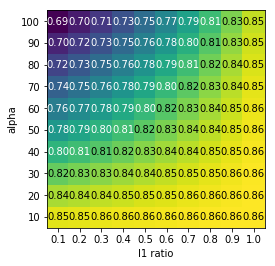

In [86]:
# For ElasticNet, plot a heatmap alpha × l1_ratio → R2 using test set performance.
alpha = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # More regularization

ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

score = []

for a in alpha:
    for l in ratio:
        elasticNet = ElasticNet(alpha = a, l1_ratio = l).fit(X_train, y_train)
        
        score.append(elasticNet.score(X_test, y_test))
        
score_map = np.array(score).reshape(10, 10)

# Visualize as a heat map
mglearn.tools.heatmap(score_map, xlabel = 'l1 ratio', xticklabels = ratio, ylabel = 'alpha', yticklabels = alpha, cmap = "viridis");

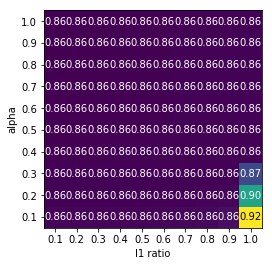

In [87]:
# Alpha smaller than 1.0
alpha_less = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # Less regularization
score = []

for a in alpha_less:
    for l in ratio:
        elasticNet = ElasticNet(alpha = a, l1_ratio = l).fit(X_train, y_train)
        
        score.append(elasticNet.score(X_test, y_test))
        
score_map = np.array(score).reshape(10, 10)

# Visualize as a heat map
mglearn.tools.heatmap(score_map, xlabel = 'l1 ratio', xticklabels = ratio, ylabel = 'alpha', yticklabels = alpha_less, cmap = "viridis");

**Performance**

The optimal performance of Ridge is 0.93, of Lasso is 0.92 and of ElasiticNet is 0.92. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization and smaller values (alpha less than 1.0) decreases the regularization. We see in the figures that increasing the regularization result in less accurate models. 

4 . Visualize the coefficients of the optimized models. Do they agree on which features are
important? Compare the results with the feature importances returned by a RandomForest. Does it agree with the linear models? What would look for when scouting for a baseball player?

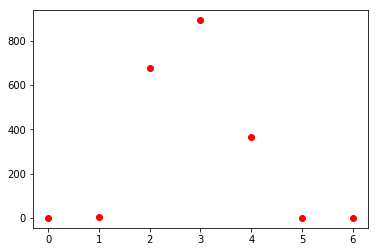

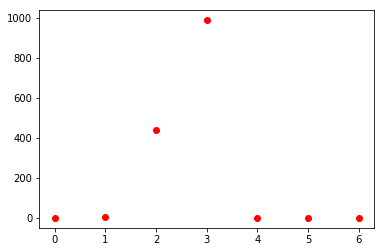

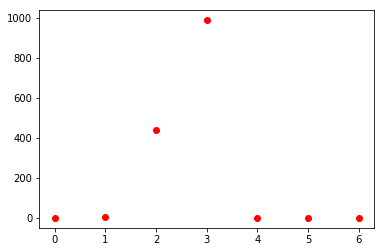

In [84]:
# Visualize the coefficients of the optimized models

# Ridge
ridge = Ridge(alpha = 0.1).fit(X_train, y_train)
plt.plot(ridge.coef_, 'ro')
plt.show()

# Lasso
lasso = Lasso(alpha = 0.1).fit(X_train, y_train)
plt.plot(lasso.coef_, 'ro')
plt.show()

# ElasticNet
elasticNet = ElasticNet(alpha = 0.1, l1_ratio = 1.0).fit(X_train, y_train)
plt.plot(elasticNet.coef_, 'ro')
plt.show()

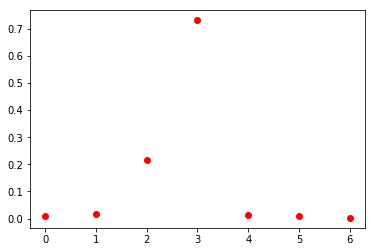

In [96]:
# Feature importances returned by a RandomForest.
rndforest = RandomForestRegressor().fit(X_train, y_train)
plt.plot(rndforest.feature_importances_ , 'ro')
plt.show()

**Important features**

The number 0 to 6 on the x-axis correspond to the 7 features that are used as input to the algorithms. The features that are important are features 2 and 3, which are OBP and SLG. According to Ridge regression also feature 4 (BA) is an important feature, but the other algorithms do not agree on that. The results of the feature importances returned by RandomForest with the default settings agree with the linear models. For scouting a baseball player it is best to base the scouting on the features OBP and SLG. We already saw in the 2d scatterplots a linear dependency of these features with the target.  

## Nepalese character recognition (5 points, 1+2+2)
The [Devnagari-Script dataset](https://www.openml.org/d/40923) contains 92,000 images (32x32 pixels) of 46 characters from Devanagari script. Your goal is to learn to recognize the right letter given the image.

In [88]:
devnagari = oml.datasets.get_dataset(40923) # Download Devnagari data
# Get the predictors X and the labels y
X, y = devnagari.get_data(target=devnagari.default_target_attribute); 
classes = devnagari.retrieve_class_labels(target_name='character') # This one takes a while, skip if not needed

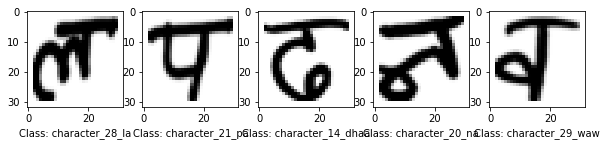

In [50]:
from random import randint
# Take some random examples, reshape to a 32x32 image and plot
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,90000)
    axes[i].imshow(X[n].reshape(32, 32), cmap=plt.cm.gray_r)
    axes[i].set_xlabel("Class: %s" % (classes[y[n]]))
plt.show();

1. Evaluate k-Nearest Neighbors, Logistic Regression and RandomForests with their default settings.
    - Take a stratified 10% subsample of the data.
    - Use the default train-test split and predictive accuracy. Is predictive accuracy a good scoring measure for this problem?
    - Try to build the same models on increasingly large samples of the dataset (e.g. 10%, 20%,...). Plot the training time and the predictive performance for each. Stop when the training time becomes prohibitively large (this will be different for different models). 

In [89]:
# Take stratified 10% subsample 
X_sample, X_temp, y_sample, y_temp = train_test_split(X, y, train_size = 0.10, test_size = 0.90, stratify = y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample)

In [16]:
# Predictive accuracy
knn = KNeighborsClassifier().fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print("knn score (accuracy): {:.2f}".format(knn.score(X_test, y_test)))

logreg = LogisticRegression().fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score (accuracy): {:.2f}".format(logreg.score(X_test, y_test)))

rndforest = RandomForestClassifier().fit(X_train, y_train)
pred_rndforest = rndforest.predict(X_test)
print("rndforest score (accuracy): {:.2f}".format(rndforest.score(X_test, y_test)))

knn score (accuracy): 0.75
logreg score (accuracy): 0.48
rndforest score (accuracy): 0.57


**Predictive Accuracy**

Predictive accuracy is a good scoring measure for this problem. But accuracy can be misleading because it tends to bias if the class is over represented in the dataset. E.g. If a dataset consits of 90% label 'A', and a model always predicts 'A' it is 90% accurate. But we could argue that this is not a good model.

For the further continuation of this question we assume accuracy is a good measure.

0.025
0.05
0.075
0.1
0.125
0.15
0.175
0.2


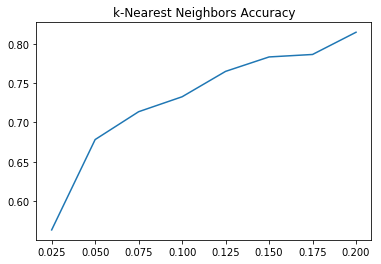

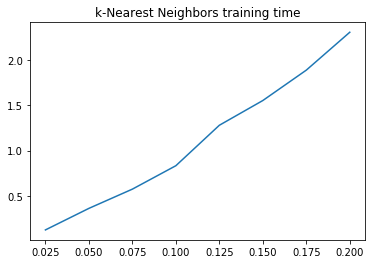

In [19]:
# Plots of training time and predictive performance for increasing subsample

# k-Nearest Neighbors
accuracy = []
trainingtime = []

# Take stratified subsample
samples = [0.025, 0.05, 0.075, 0.1, 0.125, 0.150, 0.175, 0.2]
for sample in samples:
    print(sample)
    X_sample, X_temp, y_sample, y_temp = train_test_split(X, y, train_size = sample, test_size = 1-sample, stratify = y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample)
    
    start = time.time()
    knn = KNeighborsClassifier().fit(X_train, y_train)
    end = time.time()
    
    pred_knn = knn.predict(X_test)
    
    accuracy.append(knn.score(X_test, y_test))
    trainingtime.append(end - start)

plt.plot([0.025, 0.05, 0.075, 0.1, 0.125, 0.150, 0.175, 0.2], accuracy)
plt.title("k-Nearest Neighbors Accuracy")
plt.show()

plt.plot([0.025, 0.05, 0.075, 0.1, 0.125, 0.150, 0.175, 0.2], trainingtime)
plt.title("k-Nearest Neighbors training time")
plt.show()

0.02
0.04
0.06
0.08
0.1


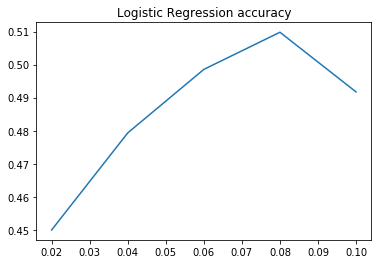

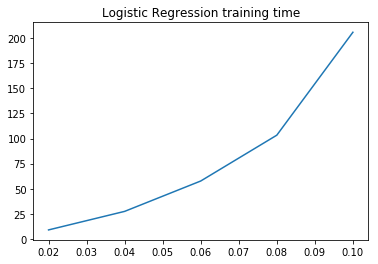

In [91]:
# Logistic Regression
accuracy = []
trainingtime = []

# Take stratified subsample
samples = [0.02, 0.04, 0.06, 0.08, 0.1]
for sample in samples:
    print(sample)
    X_sample, X_temp, y_sample, y_temp = train_test_split(X, y, train_size = sample, test_size = 1-sample, stratify = y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample)
    
    start = time.time()
    logreg = LogisticRegression().fit(X_train, y_train)
    end = time.time()
    
    pred_logreg = logreg.predict(X_test)
    
    accuracy.append(logreg.score(X_test, y_test))
    trainingtime.append(end - start)

plt.plot([0.02, 0.04, 0.06, 0.08, 0.1], accuracy)
plt.title("Logistic Regression accuracy")
plt.show()

plt.plot([0.02, 0.04, 0.06, 0.08, 0.1], trainingtime)
plt.title("Logistic Regression training time")
plt.show()

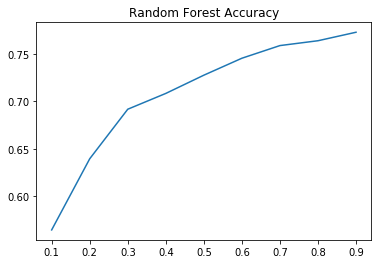

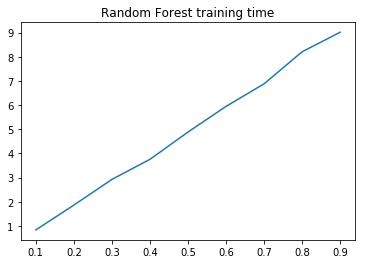

In [156]:
# Random Forest
accuracy = []
trainingtime = []

# Take stratified subsample
samples = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
for sample in samples:
    X_sample, X_temp, y_sample, y_temp = train_test_split(X, y, train_size = sample, test_size = 1-sample, stratify = y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample)
    
    start = time.time()
    rndforest = RandomForestClassifier().fit(X_train, y_train)
    end = time.time()
    
    pred_rndforest = rndforest.predict(X_test)
    
    accuracy.append(rndforest.score(X_test, y_test))
    trainingtime.append(end - start)

plt.plot([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90], accuracy)
plt.title("Random Forest accuracy")
plt.show()

plt.plot([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90], trainingtime)
plt.title("Random Forest training time")
plt.show()

2 . Optimize the value for the number of neighbors $k$ (keep $k$ < 50) and the number of trees (keep $n\_estimators$ < 100) on the stratified 10% subsample.
- Use 10-fold crossvalidation and plot $k$ and $n\_estimators$ against the predictive accuracy. Which value of $k$, $n\_estimators$ should you pick?

In [46]:
# Stratified 10% subsample
X_sample, X_temp, y_sample, y_temp = train_test_split(X, y, train_size = 0.10, test_size = 0.90, stratify = y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample)

In [26]:
# Optimize number of neighbors for k-Nearest Neighbors
nrOfNeighbors = [10, 20, 30, 40, 50]
accuracy = []

for k in nrOfNeighbors:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)

    scores = cross_val_score(knn, X_sample, y_sample, cv = 10)
    accuracy.append(scores.mean())

print(accuracy)

10
20
30
40
50
[0.7436956521739131, 0.7179347826086957, 0.6939130434782609, 0.6773913043478262, 0.6648913043478262]


In [42]:
nrOfNeighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9]
accuracy = []

for k in nrOfNeighbors:
    print(k)
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)

    scores = cross_val_score(knn, X_sample, y_sample, cv = 10)
    accuracy.append(scores.mean())

print(accuracy)

1
2
3
4
5
6
7
8
9
[0.7921739130434783, 0.7441304347826087, 0.7617391304347827, 0.7592391304347825, 0.7644565217391305, 0.7589130434782609, 0.758804347826087, 0.7529347826086956, 0.7477173913043479]


In [22]:
# Optimize number of trees for Random Forest
nrOfTrees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracy = []

for k in nrOfTrees:
    print(k)
    rndforest = RandomForestClassifier(n_estimators = k).fit(X_train, y_train)

    scores = cross_val_score(rndforest, X_sample, y_sample, cv = 10)
    accuracy.append(scores.mean())

print(accuracy)

10
20
30
40
50
60
70
80
90
100
[0.5943478260869566, 0.6780434782608695, 0.718804347826087, 0.7369565217391305, 0.7572826086956521, 0.7630434782608695, 0.7646739130434783, 0.773804347826087, 0.7783695652173913, 0.7807608695652173]


In [24]:
nrOfTrees = [91, 92, 93, 94, 95, 96, 97, 98, 99]
accuracy = []

for k in nrOfTrees:
    print(k)
    rndforest = RandomForestClassifier(n_estimators = k).fit(X_train, y_train)

    scores = cross_val_score(rndforest, X_sample, y_sample, cv = 10)
    accuracy.append(scores.mean())

print(accuracy)

91
92
93
94
95
96
97
98
99
[0.7739130434782608, 0.7793478260869564, 0.7759782608695651, 0.7783695652173913, 0.7794565217391304, 0.7789130434782608, 0.780108695652174, 0.7777173913043478, 0.7786956521739131]


**Neighbours**

First we avaluated `[10, 20, 30, 40, 50]` number of Nearest Neighbours, but this resulted in a declining accuracy from `k = 10` onwards. We then ran the numbers `[1, 2, 3, 4, 5, 6, 7, 8, 9]`. This resulted in different scores of which the 'k = 5' returned the highest. Therefore choose `k = 5` neighbours for our model.

**Trees**

First we avaluated `[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]` number of Trees. This results in a rising accuracy corresonding to the number of trees. Although the accuracy keeps rising up to `trees = 100`,  the accuracy does not rise much after `70` trees. We choose our number of trees to be `70`. This saves computational effort.

3 . For the RandomForest, optimize both $n\_estimators$ and $max\_features$ at the same time on the entire dataset.
- Use a nested cross-validation and a random search over the possible values, and measure the accuracy. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal performance you find?
- Hint: choose a nested cross-validation that is feasible. Don't use too many folds in the outer loop.
- Repeat the grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow ACC$ with ACC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

In [9]:
# Use a nested cross-validation and a random search over the possible values, and measure the accuracy. 
# Explore how fine-grained this grid/random search can be, given your computational resources. 
# What is the optimal performance you find?

nrOfTrees = np.arange(10, 100)
param_grid = {'n_estimators': nrOfTrees,
              'max_features': [2, 4, 6, 8, 10, 12, 14, 16]}

scores = cross_val_score(RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_grid, n_iter = 10, n_jobs=-1), X, y)

print(scores)
print(scores.max())

[0.68890555 0.70575582 0.66911477]
0.7057558177433023


The optimal performance we find is 0.71.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

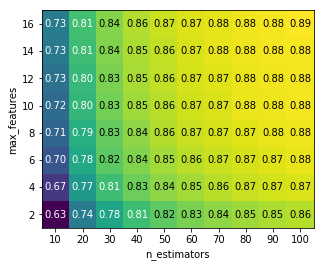

In [49]:
# Repeat the grid search and visualize the results as a plot (heatmap) 
# n_estimators × max_features → ACC
# with ACC visualized as the color of the data point. Try to make the grid as fine as possible.

param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'max_features': [2, 4, 6, 8, 10, 12, 14, 16]}

grid_search = GridSearchCV(RandomForestClassifier(n_jobs = -1), param_grid)
X_train, X_test, y_train, y_test = train_test_split(X, y)
grid_search.fit(X_train, y_train)

# Convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Visualize as a heat map
scores = np.array(results.mean_test_score).reshape(8, 10)

mglearn.tools.heatmap(scores, xlabel = 'n_estimators', xticklabels = param_grid['n_estimators'],
                      ylabel = 'max_features', yticklabels = param_grid['max_features'], cmap = "viridis");


**RandomForests**

We see that the performance increases by both the max number of features and the number of trees. For the RandomForests algorithm we know that increasing the number of trees result in a better accuracy. From the heatmap we see that the number of trees has a more positive impact on the accuracy than the max number of features. With the combination of 30 number of trees and 6 max_features the accuracy is already 0.82, which is already close to the largest value in the heatmap. Increasing the parameters do not give much added value. 

## 3. Understanding Ensembles (5 points (3+2))
Do a deeper analysis of how RandomForests and Gradient Boosting reduce their prediction error. We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). When high-energy particles hit the atmosphere, they produce chain reactions of other particles called 'showers', and you need to detect whether these are caused by gamma rays or cosmic rays.

In [6]:
# Get the data
magic_data = oml.datasets.get_dataset(1120) # Download MAGIC Telescope data
X, y = magic_data.get_data(target=magic_data.default_target_attribute);

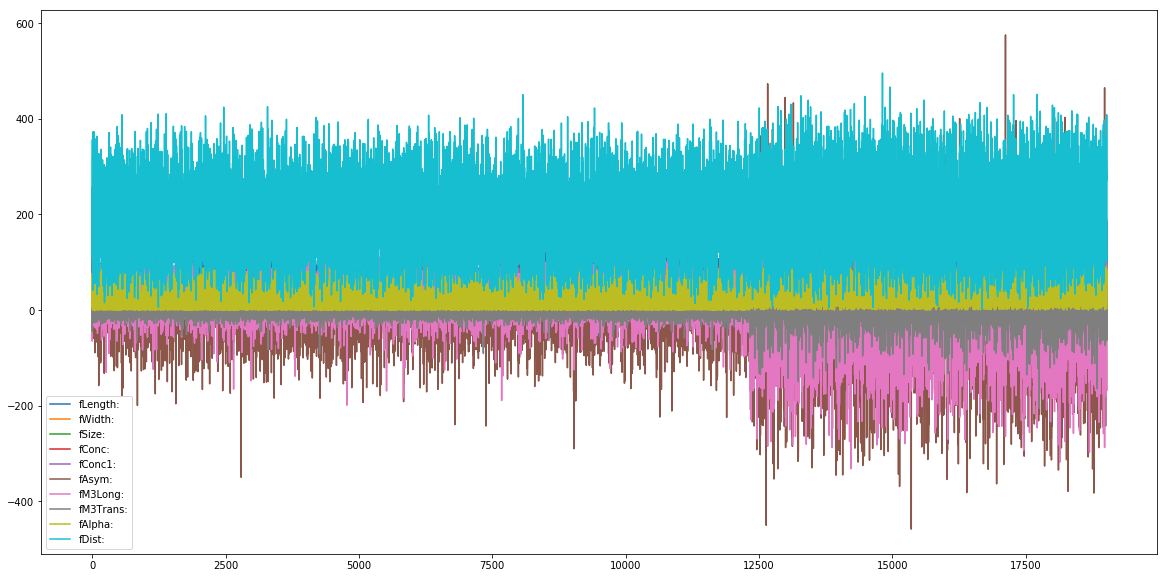

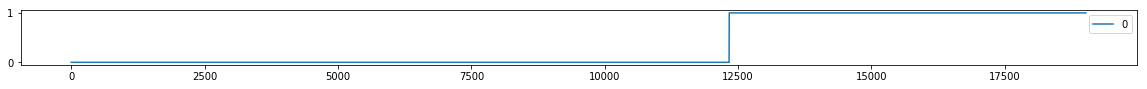

In [7]:
# Quick visualization
X, y, attribute_names = magic_data.get_data(target=magic_data.default_target_attribute, return_attribute_names=True)
magic = pd.DataFrame(X, columns=attribute_names)
magic.plot(figsize=(20,10))
# Also plot the target: 1 = gamma, 0 = background
pd.DataFrame(y).plot(figsize=(20,1));

1 . Do a bias-variance analysis of both algorithms. For each, vary the number of trees on a log scale from 1 to 1024, and plot the bias error (squared), variance, and total error (in one plot per algorithm). Interpret the results. Which error is highest for small ensembles, and which reduced most by each algorithm as you use a larger ensemble? When are both algorithms under- or overfitting? Provide a detailed explanation of why random forests and gradient boosting behave this way.
- See lecture 3 for an example on how to do the bias-variance decomposition
- To save time, you can use a 10% stratified subsample in your initial experiments, but show the plots for the full dataset in your report.

In [12]:
# Random Forest and Gradient Boosting
# We vary the number of trees with [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

nrOfTrees = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

rf_bias_sq= []
rf_var = []
rf_error = []

gb_bias_sq= []
gb_var = []
gb_error = []

for trees in nrOfTrees:
    print(trees)
    
    # Data and classifier
    rf_clf = RandomForestClassifier(n_estimators = trees)
    gb_clf = GradientBoostingClassifier(n_estimators = trees)

    # Bootstraps
    n_repeat = 100
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        rf_clf.fit(X[train_index], y[train_index])
        y_pred = rf_clf.predict(X[test_index])

        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    rf_bias_sq.append(sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)]))
    rf_var.append(sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)]))
    rf_error.append(sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)]))
    
    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        gb_clf.fit(X[train_index], y[train_index])
        y_pred = gb_clf.predict(X[test_index])

        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    gb_bias_sq.append(sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)]))
    gb_var.append(sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)]))
    gb_error.append(sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
                for i,x in enumerate(y_all_pred)]))


1
2
4
8
16
32
64
128
256
512
1024


In [13]:
print(rf_bias_sq)
print(rf_var)
print(rf_error)

print(gb_bias_sq)
print(gb_var)
print(gb_error)

[586.3031439095726, 686.5533388633872, 622.4518592808107, 607.1015032558518, 622.4028310922, 633.5001559791775, 651.8253618394828, 661.1710113036767, 670.1824396994951, 670.0790996424196, 673.8739734034691]
[666.3368560904066, 423.12666113660634, 328.94814071918495, 249.09849674415048, 187.38716890779963, 145.81984402082176, 117.13463816051542, 101.22898869632404, 91.05756030050372, 85.99090035757919, 83.51602659652983]
[1252.6399999999014, 1109.6799999999646, 951.399999999971, 856.199999999984, 809.7899999999888, 779.3199999999891, 768.959999999993, 762.3999999999961, 761.2399999999958, 756.0699999999925, 757.3899999999963]
[2027.375188305814, 2342.865598948781, 1700.2490937073003, 1548.46022073796, 1427.252200404226, 1375.9762209709688, 1354.0494585142221, 1329.6427443386021, 1297.0287553017004, 1256.2782550060085, 1223.6609254666837]
[1430.844811694202, 970.7944010512122, 661.2009062927018, 561.4297792620436, 426.75779959577784, 333.8437790290379, 256.06054148578374, 232.19725566140

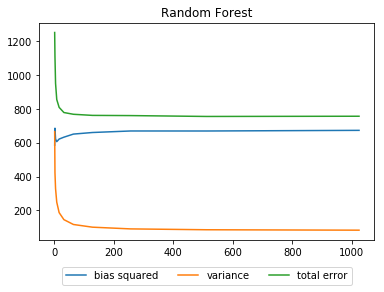

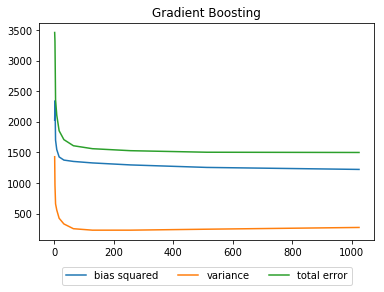

In [14]:
# plot results
plt.plot([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], rf_bias_sq)
plt.plot([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], rf_var)
plt.plot([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], rf_error)
plt.legend(['bias squared', 'variance', 'total error'], loc=9, bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.title("Random Forest")
plt.show()

plt.plot([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], gb_bias_sq)
plt.plot([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], gb_var)
plt.plot([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], gb_error)
plt.legend(['bias squared', 'variance', 'total error'], loc=9, bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.title("Gradient Boosting")
plt.show()

**Bias-variance analysis**

For small ensembles the bias error is the highest. When using a larger ensemble, the bias error reduces most by using Gradient Boosting and the variance error reduces most by using Random Forest. High bias means that you are likely underfitting and high variance means that you are likely overfitting. Boosting reduces the total error mainly by reducing bias and Random Forest by reducing the variance. So for large ensembles, General Boosting is overfitting and Random Forest is underfitting. However, Gradient Boosting is very robust to overfitting, as we also see in the figures (the variances increases only a bit when the ensemble gets larger).

The Random Forests algorithm builds many high-variance models, so overfitted models. Then, aggregation takes place (soft voting or averaging) to reduce the variance. Random Forest are therefore only used to reduce the variance and they can not reduce the bias. In contrast, the Gradient Boosting algorithm builds many high-bias models, so underfitted models. This algorithm is in contrast to Random Forests sequential: the main idea of boosting is to add new models to the ensemble sequentially.

2 . A _validation curve_ can help you understand when a model starts under- or overfitting. It plots both training and test set error as you change certain characteristics of your model, e.g. one or more hyperparameters. Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4). This will yield at least 4 curves. Interpret the results and provide a clear explanation for the results. When is the model over- or underfitting? Discuss the effect of the different combinations learning rate and tree depth and provide a clear explanation.
- While scikit-learn has a `validation_curve` function, we'll use a modified version (below) that provides a lot more detail and can be used to study more than one hyperparameter. You can use a default train-test split.

In [24]:
# Plots validation curves for every classifier in clfs. 
# Also indicates the optimal result by a vertical line
# Uses 1-AUROC, so lower is better
def validation_curve(clfs, X_test, y_test, X_train, y_train):
    for n,clf in enumerate(clfs):
        test_score = np.empty(len(clf.estimators_))
        train_score = np.empty(len(clf.estimators_))

        for i, pred in enumerate(clf.staged_decision_function(X_test)):
            test_score[i] = 1-roc_auc_score(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(X_train)):
            train_score[i] = 1-roc_auc_score(y_train, pred)

        best_iter = np.argmin(test_score)
        learn = clf.get_params()['learning_rate']
        depth = clf.get_params()['max_depth']
        test_line = plt.plot(test_score,
                             label='learn=%.1f depth=%i (%.2f)'%(learn,depth,
                                                                 test_score[best_iter]))

        colour = test_line[-1].get_color()
        plt.plot(train_score, '--', color=colour)
        
        plt.xlabel("Number of boosting iterations")
        plt.ylabel("1 - area under ROC")
        plt.axvline(x=best_iter, color=colour)
        
    plt.legend(loc='best')

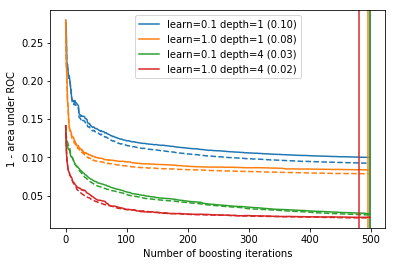

In [31]:
# Build validation curves for gradient boosting, evaluated using AUROC, by varying the number of iterations between 1 and 500. 
# In addition, use at least two values for the learning rate (e.g. 0.1 and 1), and tree depth (e.g. 1 and 4).

# n_estimators from 1 to 500
# learning_rate = [0.1, 1.0]
# max_depth = [1, 4]
clfs = []

params = {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 1}
clf = GradientBoostingClassifier(**params)
clf.fit(X[train_index], y[train_index])
clfs.append(clf)

params = {'n_estimators': 500, 'learning_rate': 1.0, 'max_depth': 1}
clf = GradientBoostingClassifier(**params)
clf.fit(X[train_index], y[train_index])
clfs.append(clf)

params = {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 4}
clf = GradientBoostingClassifier(**params)
clf.fit(X[train_index], y[train_index])
clfs.append(clf)

params = {'n_estimators': 500, 'learning_rate': 1.0, 'max_depth': 4}
clf = GradientBoostingClassifier(**params)
clf.fit(X[train_index], y[train_index])
clfs.append(clf)

X_train, X_test, y_train, y_test = train_test_split(X, y)

validation_curve(clfs, X_test, y_test, X_train, y_train)

**Discussion validation curves**

The lower the value for 1 - AUROC, the better the model. Based on the figure, the combination of learning rate = 1.0 and depth = 4 is the best parameter setting. This curve has a flatter tail, which implies that the best result is obtain the earliest (with less number of boosting iterations). The model is underfitted, when the value of 1 - AUROC is relatively high. The model is starting to overfit when more iterations do not result in a smaller value for 1 - AUROC. 

The learning rate shrinks the contribution of each tree, when smaller than 1.0. Lower rates result in that more trees are needed to get more complex models. When we compare the orange and the red curves with the blue and green curve, we see that in both cases the curves with learning rate = 1.0 score better than with learning rate = 0.1 (orange is below blue and red is below green). The maximum depth limits the number of nodes in the tree. Limiting the depth to 1 node resticts the number of features that are taken into account, which results in a less fitting.  